In [4]:
# Standard Imports
import pandas as pd
%matplotlib inline 
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot


# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


# Utilities
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

from imblearn.under_sampling import RandomUnderSampler


In [5]:
X_train = pd.read_csv('../6-X_train_FINAL.csv')
X_test = pd.read_csv('../6-X_test_FINAL.csv')
X_train=X_train.drop(['MAKE', 'VIN'], axis=1)
X_test=X_test.drop(['MAKE', 'VIN'], axis=1)

In [6]:
# Dropping Nulls
X_train = X_train.dropna(axis=0)
X_test = X_test.dropna(axis=0)

In [7]:
X_train = X_train[X_train['GVW_TYPE'].notna()]
X_test = X_test[X_test['GVW_TYPE'].notna()]

X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(int)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(int)

X_train['VEHICLE_TYPE'] = X_train['VEHICLE_TYPE'].astype(str)
X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(str)
X_train['FINAL_CYL'] = X_train['FINAL_CYL'].astype(str)
X_train['OBD_MIL_STATUS'] = X_train['OBD_MIL_STATUS'].astype(bool)

X_test['VEHICLE_TYPE'] = X_test['VEHICLE_TYPE'].astype(str)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(str)
X_test['FINAL_CYL'] = X_test['FINAL_CYL'].astype(str)
X_test['OBD_MIL_STATUS'] = X_test['OBD_MIL_STATUS'].astype(bool)

In [8]:
X_train.OBD_MIL_STATUS.value_counts()


True     115712
False      3597
Name: OBD_MIL_STATUS, dtype: int64

In [9]:
# getting target feature
y_train = X_train['OVERALL_RESULT']
X_train = X_train.drop('OVERALL_RESULT', axis='columns')
y_train = LabelEncoder().fit_transform(y_train)

y_test = X_test['OVERALL_RESULT']
X_test = X_test.drop('OVERALL_RESULT', axis='columns')
y_test = LabelEncoder().fit_transform(y_test)

In [10]:
print(len(X_train))
print(len(y_train))

119309
119309


In [11]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119309 entries, 0 to 126744
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   FINAL_CYL       119309 non-null  object 
 1   CAR_AGE         119309 non-null  float64
 2   GVW_TYPE        119309 non-null  object 
 3   TRANS_TYPE      119309 non-null  object 
 4   DUAL_EXHAUST    119309 non-null  object 
 5   FUEL_TYPE       119309 non-null  object 
 6   VEHICLE_TYPE    119309 non-null  object 
 7   OBD_MIL_STATUS  119309 non-null  bool   
 8   MODEL_YEAR      119309 non-null  int64  
 9   ODOMETER        119309 non-null  float64
 10  AVG_MIL_YEARLY  119309 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 10.1+ MB


In [13]:
categorical_columns = X_train[['ODOMETER','AVG_MIL_YEARLY']].select_dtypes(include='object').columns
len(categorical_columns)


0

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate



def cross_validate(
    cv,
    balancing_technique,
    model,
    nameTest,
    Comb_X_train,
    Comb_X_test):

    categorical_columns = Comb_X_train.select_dtypes(include='object').columns

    pipeline = make_pipeline(balancing_technique, model)

    if (len(categorical_columns) > 0):
        print(':::::::CATEGORICAL FEATURES FOUND:::::::')
        cat_pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )

        preprocessor_linear = make_column_transformer(
            (cat_pipe, categorical_columns),
            n_jobs=2,
        )

        pipeline = make_pipeline(
            balancing_technique, preprocessor_linear, model)

    train_acc = []
    test_acc = []
    test_prec = []
    test_recall = []
    test_f1 = []

    for train_ind, val_ind in cv.split(Comb_X_train, y_train):
        X_t, y_t = Comb_X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))

        X_val, y_val = Comb_X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))

        y_pred = pipeline.predict(Comb_X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        F1Sc = f1_score(y_test, y_pred)
        test_prec.append(precision)
        test_recall.append(recall)
        test_f1.append(F1Sc)
    print(classification_report(y_val, y_hat_val))
    cm = confusion_matrix(y_val, y_hat_val)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('Test Precision: {}'.format(np.mean(test_prec)))
    print('Test Recall: {}'.format(np.mean(test_recall))) 
    print('Test F1: {}'.format(np.mean(test_f1))) 
    print('\n')

    return [nameTest,
        np.mean(train_acc),
        np.mean(test_acc),
        np.mean(test_prec),
        np.mean(test_recall),
        np.mean(test_f1)]

In [15]:
import itertools as iter

def permutationsCars(lst):
    comb = (iter.combinations(lst, l) for l in range(len(lst) + 1))
    return list(iter.chain.from_iterable(comb))

def listing(lst):
  return list(lst)

#Number of values to use if automatically
var = 10

#ENTER ALL POSSIBLE COLUMNS HERE
listsTries = X_train.columns
permutations = permutationsCars(X_train.columns)
iterationsIndex = permutations[len(listsTries)+1:len(listsTries)*(len(listsTries) - 5)+1]

#AUTOMATIC FROM DF
#permutations = permutationsCars(X_train.columns[:var])
#iterationsIndex = permutations[var+1:]

ColumnNamesPermutation = []
for x in iterationsIndex:
  ColumnNamesPermutation.append(listing(x))

In [16]:
ColumnNamesPermutation

[['FINAL_CYL', 'CAR_AGE'],
 ['FINAL_CYL', 'GVW_TYPE'],
 ['FINAL_CYL', 'TRANS_TYPE'],
 ['FINAL_CYL', 'DUAL_EXHAUST'],
 ['FINAL_CYL', 'FUEL_TYPE'],
 ['FINAL_CYL', 'VEHICLE_TYPE'],
 ['FINAL_CYL', 'OBD_MIL_STATUS'],
 ['FINAL_CYL', 'MODEL_YEAR'],
 ['FINAL_CYL', 'ODOMETER'],
 ['FINAL_CYL', 'AVG_MIL_YEARLY'],
 ['CAR_AGE', 'GVW_TYPE'],
 ['CAR_AGE', 'TRANS_TYPE'],
 ['CAR_AGE', 'DUAL_EXHAUST'],
 ['CAR_AGE', 'FUEL_TYPE'],
 ['CAR_AGE', 'VEHICLE_TYPE'],
 ['CAR_AGE', 'OBD_MIL_STATUS'],
 ['CAR_AGE', 'MODEL_YEAR'],
 ['CAR_AGE', 'ODOMETER'],
 ['CAR_AGE', 'AVG_MIL_YEARLY'],
 ['GVW_TYPE', 'TRANS_TYPE'],
 ['GVW_TYPE', 'DUAL_EXHAUST'],
 ['GVW_TYPE', 'FUEL_TYPE'],
 ['GVW_TYPE', 'VEHICLE_TYPE'],
 ['GVW_TYPE', 'OBD_MIL_STATUS'],
 ['GVW_TYPE', 'MODEL_YEAR'],
 ['GVW_TYPE', 'ODOMETER'],
 ['GVW_TYPE', 'AVG_MIL_YEARLY'],
 ['TRANS_TYPE', 'DUAL_EXHAUST'],
 ['TRANS_TYPE', 'FUEL_TYPE'],
 ['TRANS_TYPE', 'VEHICLE_TYPE'],
 ['TRANS_TYPE', 'OBD_MIL_STATUS'],
 ['TRANS_TYPE', 'MODEL_YEAR'],
 ['TRANS_TYPE', 'ODOMETER'],
 ['TR

In [17]:
len(ColumnNamesPermutation)

55

:::::::CATEGORICAL FEATURES FOUND:::::::
              precision    recall  f1-score   support

           0       0.07      0.65      0.13      1511
           1       0.95      0.43      0.59     22350

    accuracy                           0.44     23861
   macro avg       0.51      0.54      0.36     23861
weighted avg       0.89      0.44      0.56     23861

Training Accuracy: 0.4375822390532558


Validation Accuracy: 0.4373350118025468
Test Precision: 0.9509193555918098
Test Recall: 0.4190554738767167
Test F1: 0.581730849828724


:::::::CATEGORICAL FEATURES FOUND:::::::
              precision    recall  f1-score   support

           0       0.07      0.59      0.13      1511
           1       0.95      0.50      0.65     22350

    accuracy                           0.50     23861
   macro avg       0.51      0.54      0.39     23861
weighted avg       0.89      0.50      0.62     23861

Training Accuracy: 0.490922703942415


Validation Accuracy: 0.4904157421862633
Test Prec

KeyboardInterrupt: 

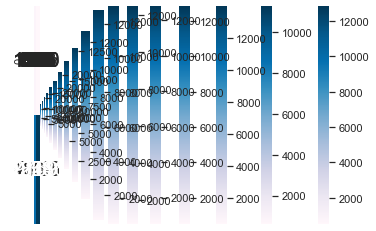

In [18]:
Models = []
counter = 0
#Random Forest as model chosen
model = RandomForestClassifier(n_estimators=100, random_state=0)

for i,x in enumerate(ColumnNamesPermutation):

  #Balancing technique: UnderSampling
  balancing_technique = RandomUnderSampler(random_state=0)
  nameTest = str(ColumnNamesPermutation[i])

  printColumnNamesPermutation()

  #Evaluating the model

  Models.append(cross_validate(
    KFold(),
    balancing_technique,
    model,
    nameTest, 
    X_train[ColumnNamesPermutation[i]],
    X_test[ColumnNamesPermutation[i]]))
  counter += 1

In [61]:
ModelsDf =pd.DataFrame(Models)
ModelsDf.columns = ["Variables_Used","TrainAccuracy","ValAccuracy","Precision","Recall","F1Score"]


In [62]:
ModelsDf.iloc[ModelsDf['TrainAccuracy'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [63]:
ModelsDf.iloc[ModelsDf['ValAccuracy'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [64]:
ModelsDf.iloc[ModelsDf['Precision'].idxmax()]

Variables_Used    ['CAR_AGE', 'FUEL_TYPE']
TrainAccuracy                    0.0763564
ValAccuracy                      0.0763564
Precision                         0.979263
Recall                           0.0152401
F1Score                          0.0300131
Name: 13, dtype: object

In [65]:
ModelsDf.iloc[ModelsDf['Recall'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [66]:
ModelsDf.iloc[ModelsDf['F1Score'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [67]:
ModelsDf.to_csv("./drive/MyDrive/cars/RandomForestResultsOnlyPairs.csv")
